In [1]:
%load_ext autoreload

In [2]:
from __future__ import print_function

%autoreload 2
import sys
sys.path.insert(1, '../src')

import numpy as np
import pandas as pd
import copy
import json
import requests
import matplotlib.pyplot as plt
import datetime
from time import time

#Local utils
from utils.utility_functions import remove_dollar, per_float, toYears, timer

#scikit-learn dependencies
from sklearn import preprocessing
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_validate
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.externals import joblib
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

#Metrics
from sklearn.metrics import f1_score, recall_score, roc_auc_score, roc_curve, auc

#Feature selection
from sklearn.feature_selection import SelectKBest, chi2, SelectFromModel

#Sampling
from imblearn.over_sampling import SMOTE

%matplotlib inline

/usr/local/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


## EDA

In [ ]:
raw_train.columns

In [ ]:
raw_train['y'].describe()

In [ ]:
sns.distplot(raw_train['y'])

In [ ]:
raw_train['y'].value_counts()

In [ ]:
def normalize(column):
    upper = column.max()
    lower = column.min()
    y = (column - lower)/(upper-lower)
    return y

y_normalized = normalize(raw_train.y)

In [ ]:
y_normalized.value_counts()

In [ ]:
y_normalized.describe()

## <u>Sampling methods</u>

### Oversample

In [ ]:
from sklearn.utils import resample

def get_resample(raw, raw_y, len_train):
    train_x, test_x, train_y, test_y, holdout_x, holdout_y = split_data(raw,raw_y,len_train)

    # concatenate training data back
    X = pd.concat([train_x, train_y], axis=1)

    # separate minority and majority classes
    not_fraud = X[X.y==0]
    fraud = X[X.y==1]

    # upsample minority
    upsampled_m = resample(fraud,
                        replace=True, 
                        n_samples=len(not_fraud), 
                        random_state=27)

    # combine majority and upsampled minority
    upsampled = pd.concat([not_fraud, upsampled_m])
    return unsampled

### Synthetic

In [ ]:
y_normalized.value_counts()

In [ ]:
x = raw[:len_train]
y = raw_y[:len_train]

# Initial train/test split
training_features, test_features, training_target, test_target = train_test_split(x, y, 
                                                                                  test_size=0.2, 
                                                                                  random_state=42)

# Split into validation sets
x_train, x_val, y_train, y_val = train_test_split(training_features, training_target,
                                                  test_size = 0.1,
                                                  random_state = 12)
# SMOTE oversampling
sm = SMOTE(random_state=12, ratio = 1.0)
x_train_res, y_train_res = sm.fit_sample(x_train, y_train)

# Instantiate model
rfc = RandomForestClassifier(bootstrap=True,
                             criterion='gini',
                             max_depth=25,
                             n_estimators=150,
                             random_state=12,
                             n_jobs=-1)

# Train data
rfc.fit(x_train_res, y_train_res)


In [ ]:
y_train_int = y_train_res.astype(int)
np.bincount(y_train_int)

## Feature Selection EDA

#### Extra Trees

In [ ]:
from sklearn.ensemble import ExtraTreesRegressor

def fs_extra_trees(train_x, train_y):
    model = ExtraTreesRegressor(n_estimators=100, n_jobs=-1)
    model.fit(train_x, train_y)
    
    return model

In [ ]:
extra_trees_model = fs_extra_trees(train_x, train_y)

In [ ]:
for feature in zip(train_x.columns, extra_trees_model.feature_importances_):
    print(feature)

#### Random Forest feature selection

In [ ]:
def fs_random_forest(train_x, train_y, n):    
    clf = RandomForestRegressor(n_estimators=n, random_state=0, n_jobs=-1)
    clf.fit(train_x, train_y)
    
    return clf

# # Print the name and gini importance of each feature
# for feature in zip(feat_labels, clf.feature_importances_):
#     print(feature)

In [ ]:
n = len(train_x.columns)

fs_rf_model = fs_random_forest(train_x, train_y, n)

In [ ]:
for feature in zip(train_x.columns, fs_rf_model.feature_importances_):
    print(feature)

#### Recursive Feature Selection

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# Feature extraction
model = LogisticRegression(solver='lbfgs')
rfe = RFE(model, n_features_to_select=30, step=1)
fit = rfe.fit(train_x, train_y)
print("Num Features: %s" % (fit.n_features_))
# print("Selected Features: %s" % (fit.support_))
print("Feature Ranking: %s" % (fit.ranking_))

support = fit.support_
# features = train_x.columns
# features[support]

In [ ]:
from sklearn.svm import LinearSVC

svm = LinearSVC()
n = int(len(s_train_x.columns))
rfe = RFE(svm, n_features_to_select=n)
fit = rfe.fit(s_train_x, s_train_y)
# print summaries for the selection of attributes
print(fit.support_)
print(fit.ranking_)

In [ ]:
def elim(X, y, n_features):
    model = RandomForestRegressor(n_estimators=50)
#     model = GradientBoostingRegressor(n_estimators=50, learning_rate=0.05)

    feat_selector = RFE(estimator=model, step=1, n_features_to_select=n_features)
    feat_selector.fit_transform(X.values, y.values)

    features_bool = np.array(feat_selector.support_)
    features = np.array(X.columns)
    result = features[features_bool]
    features_rank = feat_selector.ranking_
    rank = features_rank[features_bool]

    return result, features_rank, rank 

result, features_rank, rank  = elim(s_train_x, s_train_y, 100)

In [ ]:
def test_compare_with_no_feature_selection():
    '''
    compare the result before the selection and after
    :return: None
    '''
    X = raw[:len_train]
    y = raw_y[:len_train]
    estimator=LinearSVC()
    selector=RFE(estimator=estimator,n_features_to_select=2)
    X_t=selector.fit_transform(X,y)
    X_train,X_test,y_train,y_test=cross_validation.train_test_split(X, y,
                test_size=0.25,random_state=0,stratify=y)
    X_train_t,X_test_t,y_train_t,y_test_t=cross_validation.train_test_split(X_t, y,
                test_size=0.25,random_state=0,stratify=y)
    clf=LinearSVC()
    clf_t=LinearSVC()
    clf.fit(X_train,y_train)
    clf_t.fit(X_train_t,y_train_t)
    print("Original DataSet: test score=%s"%(clf.score(X_test,y_test)))
    print("Selected DataSet: test score=%s"%(clf_t.score(X_test_t,y_test_t))) 

In [ ]:
test_compare_with_no_feature_selection()

#### Statsmodels feature selection

In [ ]:
import statsmodels.api as sm

#Adding constant column of ones, mandatory for sm.OLS model
def statsmodels_feature_selection(train_x, train_y):
    X_1 = sm.add_constant(train_x)
    model = sm.OLS(train_y, X_1).fit()
    model_pvalues = model.pvalues
    model_pvalues_df = pd.DataFrame({'feature':model_pvalues.index, 'p_values':model_pvalues.values})
    filtered_model_pv = model_pvalues_df[model_pvalues_df['p_values'] <= 0.05]
    important_features = filtered_model_pv['feature'].tolist()
    
    return important_features

important_features_norm = statsmodels_feature_selection(train_x, train_y)
important_features_scaled = statsmodels_feature_selection(s_train_x, s_train_y)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=[0, 1])
raw_rescaled = scaler.fit_transform(raw)
scaled_df = pd.DataFrame(raw_rescaled, columns=train_x.columns)
x = scaled_df[:len_train]
y = raw_y[:len_train]
s_train_x, s_test_x, s_train_y, s_test_y = train_test_split(x, y, test_size=0.3, random_state=42)

In [ ]:
def load_data(train_path, test_path):
    raw_train = pd.read_csv(train_path)
    raw_test = pd.read_csv(test_path)
    return raw_train, raw_test

In [ ]:
raw[[c for c in raw.columns if c in important_features_norm]]

## Model Comparisons

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the n

LR: 0.476479 (0.005092)
LDA: 0.615737 (0.057013)


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


KNN: 0.946359 (0.012543)


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


CART: 0.830155 (0.033063)


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


RF: 0.994191 (0.006401)


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


NB: 0.502972 (0.000957)


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


SVM: 0.501766 (0.005156)


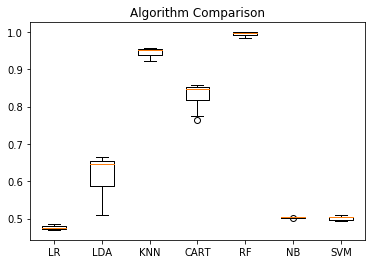

In [12]:
# from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

models = []
models.append(('LR', LogisticRegression(class_weight='balanced')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('RF', RandomForestClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

results = []
names = []
for name, model in models:
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='roc_auc')
    results.append(cv_results)
    names.append(name)
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
# Compare Algorithms
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison')
plt.show()

## Run Pipeline

In [5]:
@timer
def load_data(train_path, test_path):
    raw_train = pd.read_csv(train_path)
    raw_test = pd.read_csv(test_path)
    return raw_train, raw_test

@timer
def feature_selection(raw_train, raw_test):
    # Drop NULL values in column x1
    raw_train_drop = raw_train.dropna(axis=0,subset=['y'])
    
    len_train = len(raw_train_drop)
    len_test = len(raw_test)
    
    # Combine train and test data
    list_all=[raw_train_drop,raw_test]
    raw = pd.concat(list_all, ignore_index=True, sort=True)
    
    del(raw_train, raw_test, raw_train_drop)
    
    # Get percentage of NULL values for each feature
    null_list = raw.isnull().sum().sort_values(ascending=False)/float(raw.shape[0])*100
    #print('\nThe percentage of NUll value in each features are:', null_list[:10])
    
    #remove features not used for modeling
    del raw['x2']
    del raw['x3']
    del raw['x19']

    #These feature need Nature Language Processing before using, thus increasing the complexity of current model
    del raw['x10']
    del raw['x16']
    del raw['x18']

    #Remove redundant feature
    del raw['x8']
    
    return raw, len_train, len_test

@timer
def feature_engineering(raw):
    raw['x4'] = raw['x4'].apply(remove_dollar)
    raw['x5'] = raw['x5'].apply(remove_dollar)
    raw['x6'] = raw['x6'].apply(remove_dollar)
    raw['x12'] = raw['x12'].apply(remove_dollar)
    
    raw['x30'] = raw['x30'].apply(per_float)
    
    # Create new features to be used in modeling
    raw['x33'] = raw['x5']/raw['x4']
    raw['x34'] = raw['x6']/raw['x5']    
    
    raw['x15'] = raw['x15'].apply(toYears)
    raw['x23'] = raw['x23'].apply(toYears)
 
    # Time difference between issue date and the date opened
    raw['x35'] = raw['x15']  - raw['x23']
    
    ### Set target variable and remove it from input variable list
    raw_y = raw['y']
    del raw['y']    
    
    return raw, raw_y

@timer
def cat_numerical_data_preparation(raw):
    cat_cols = raw.dtypes[raw.dtypes == 'object'].index
    num_cols = raw.dtypes[raw.dtypes == 'float64'].index
    
    # Make a copy of raw input, will be used later as input variables in the linear regression model 
    raw_bp_linear = copy.deepcopy(raw)
    
    # Replace the Null value with very large number (10**20), let tree model to interpret by itself
    for i in num_cols:
        raw[i].fillna(10**20,inplace=True)
        
    return cat_cols, num_cols, raw_bp_linear, raw

@timer    
def label_encoding(raw):
    # Label encoding for categorical feature
    LBL = preprocessing.LabelEncoder()
    dict_list = []
    for i in cat_cols:
        raw[i] = LBL.fit_transform(raw[i].fillna('0'))
        j = dict(zip(np.arange(len(LBL.classes_)),LBL.classes_))
        k = {i:j}
        dict_list.append(k)

    return raw, dict_list
    
@timer    
def split_data(raw, raw_y, len_train, important_features=None):
    ### Split into training and test dataset
    if important_features:
        raw = raw[[c for c in raw.columns if c in important_features_norm]]
    x = raw[:len_train]
    y = raw_y[:len_train]

    # Initial train/test split
    training_features, test_features, training_target, test_target = train_test_split(x, y, 
                                                                                      test_size=0.2, 
                                                                                      random_state=42)

    # Split into validation sets
    x_train, x_val, y_train, y_val = train_test_split(training_features, training_target,
                                                      test_size = 0.1,
                                                      random_state = 12)
    # SMOTE oversampling
    sm = SMOTE(random_state=12)
    x_train_res, y_train_res = sm.fit_sample(x_train, y_train)
    
    return x_train_res, test_features, y_train_res, test_target

@timer
def random_grid_search(train_x, train_y):
    # Number of trees in random forest
    n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
    # Number of features to consider at every split
    max_features = ['auto', 'sqrt']
    # Maximum number of levels in tree
    max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
    max_depth.append(None)
    # Minimum number of samples required to split a node
    min_samples_split = [2, 5, 10]
    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 2, 4]
    # Method of selecting samples for training each tree
    bootstrap = [True, False]
    # Create the random grid
    random_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}

    # Using the random grid to search for best hyperparameters
    # First create the base model to tune
    rf = RandomForestRegressor()
    # Random search of parameters, using 3 fold cross validation, 
    # search across 100 different combinations, and use all available cores
    rf_random = RandomizedSearchCV(estimator = rf, 
                                   param_distributions = random_grid, 
                                   n_iter = 50, 
                                   cv = 3, 
                                   verbose=2, 
                                   random_state=42, 
                                   n_jobs = -1)
    # Fit the random search model
    rf_random.fit(train_x, train_y)
    print("Random Forest-Random Grid Search Best Params: {}".format(rf_random.best_params_))
    
    return rf_random

@timer
def test_random_grid_against_base(rf_random, train_x, train_y, test_x, test_y):
    def evaluate(model, test_features, test_labels):
        predictions = model.predict(test_features)
        errors = abs(predictions - test_labels)
        mape = 100 * np.mean(errors / test_labels)
        accuracy = 100 - mape
        print('Model Performance')
        print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
        print('Accuracy = {:0.2f}%.'.format(accuracy))

        return accuracy

    base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
    base_model.fit(train_features, train_labels)
    base_accuracy = evaluate(base_model, test_features, test_labels)

    best_random = rf_random.best_estimator_
    random_accuracy = evaluate(best_random, test_features, test_labels)

    print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))
          
    return base_model, base_accuracy, best_random, random_accuracy

@timer
def random_forest_regressor(train_x, train_y, pkl_model):
    # Develop a random forest model with 'n_estimators' = best_estimators
    print('\nRandom forest regressor model is developing...')
    rfr_best = RandomForestRegressor(bootstrap=True,
                                     criterion='mse',
                                     max_depth=None,
                                     n_estimators=150, 
                                     n_jobs=-1)
    rfr_best.fit(train_x, train_y)
    
    ### Save the model in local disk
    joblib.dump(rfr_best, pkl_model)
    
    return rfr_best

@timer
def random_forest_classifier(x_train_res, y_train_res, pkl_model, n_estimators=170, max_depth=11):
    # Develop a random forest model with 'n_estimators' = best_estimators
    print('\nRandom forest classifier model is developing...')
    rfc_best = RandomForestClassifier(bootstrap=True,
                                     criterion='gini',
                                     max_depth=max_depth,
                                     n_estimators=n_estimators,
                                     random_state=42,
                                     n_jobs=-1)
    
    rfc_best.fit(x_train_res, y_train_res)
    
    ### Save the model in local disk
    joblib.dump(rfc_best, pkl_model)
    print('\nRandom forest classifier has finished running and is saved as: {}\n'.format(pkl_model))
    
    return rfc_best

    
    
if __name__ == '__main__':
    
    ## Define hyper paramaters/variables ===================================
    param_grid = { 
        'n_estimators': [60,120,180]
    }
    
    test_path = '../Data/test.csv'
    train_path = '../Data/train.csv'

    ## Run Model =====================================================
    # Load data
    raw_train, raw_test = load_data(train_path, test_path)
    
    # Feature selection
    raw, len_train, len_test = feature_selection(raw_train, raw_test)
    
    # Feature engineering
    raw, raw_y = feature_engineering(raw)
    
    # Data prep
    cat_cols, num_cols, raw_bp_linear, raw = cat_numerical_data_preparation(raw)
    
    # Encoding
    raw, dict_list = label_encoding(raw)
    
    # Split
    X_train, X_test, y_train, y_test = split_data(raw, raw_y, len_train, important_features=None)
    
    ##random grid      
    #rf_random = random_grid_search(train_x, train_y)      
    
    ##test random against base
    #base_model, base_accuracy, best_random, random_accuracy = test_random_grid_against_base(rf_random, train_x, train_y, test_x, test_y)

    ##param search
    #CV_rfr, best_estimator = cv_grid_search(train_x, train_y, param_grid=param_grid, cv=5)
    
    ##train & save model
    #rfr_best = random_forest_regressor(train_x, train_y, pkl_model)
    
#     rfc_best = random_forest_classifier(train_x, train_y, pkl_model_cls)


Function 'load_data' finished. Runtime: 1.5462 secs
Function 'feature_selection' finished. Runtime: 0.5815 secs
Function 'feature_engineering' finished. Runtime: 0.7939 secs
Function 'cat_numerical_data_preparation' finished. Runtime: 0.1333 secs
Function 'label_encoding' finished. Runtime: 0.0811 secs
Function 'split_data' finished. Runtime: 4.5287 secs


In [10]:
from collections import Counter

print('X_train shape:',X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

print('\nTrain unique counts:',sorted(Counter(y_train).items()))
print('Test unique counts:',sorted(Counter(y_test).items()))

X_train shape: (45912, 93)
X_test shape: (8000, 93)
y_train shape: (45912,)
y_test shape: (8000,)

Train unique counts: [(0.0, 22956), (1.0, 22956)]
Test unique counts: [(0.0, 6391), (1.0, 1609)]


## Metrics

In [ ]:
from joblib import load

pkl_model_cls = '../app/rfc_model.pkl'

rfc_load = load(pkl_model_cls)
print('\nLoaded Random Forest model.')

train_y_pred = rfc_load.predict(X_train)
print('\nTrain Results')
print('Training Accuracy: {}'.format(rfc_load.score(X_train, y_train)))
print('Training AUC: {}'.format(roc_auc_score(y_train, train_y_pred)))
print('Train f1 score: {}'.format(f1_score(y_train, train_y_pred)))
print('Train Recall Score: {}'.format(recall_score(y_train, train_y_pred)))

# print('Validation Results')
# print(rfc.score(x_val, y_val))
# print(recall_score(y_val, rfc.predict(x_val)))

test_y_pred = rfc_load.predict(X_test)
print('\nTest Results')
print('Test Accuracy: {}'.format(rfc_load.score(X_test, y_test)))
print('Test AUC: {}'.format(roc_auc_score(y_test, test_y_pred)))
print('Test f1 score: {}'.format(f1_score(y_test, test_y_pred)))
print('Test Recall Score: {}'.format(recall_score(y_test, rfc_load.predict(X_test))))

In [ ]:
max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
    rf = RandomForestClassifier(max_depth=max_depth, n_jobs=-1)
    rf.fit(train_x, train_y)
    train_pred = rf.predict(train_x)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(train_y, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = rf.predict(test_x)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(test_y, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
    
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, 'b', label="Train AUC")
line2, = plt.plot(max_depths, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.show()

## Test API Call

In [15]:
test_path = '../Data/test.csv'
df = pd.read_csv(test_path, encoding="utf-8-sig")
df = df.head(5)
data = df.to_json(orient='records')

header = {'Content-Type': 'application/json', \
                  'Accept': 'application/json'}

resp = requests.post("http://0.0.0.0:5001/predict", \
                     data = json.dumps(data),\
                     headers = header)

print(resp.status_code)
resp.json()

### Test with test data

In [ ]:
"""
POST <url>/predict
"""
header = {'Content-Type': 'application/json', \
                  'Accept': 'application/json'}

resp = requests.post("http://0.0.0.0:5001/predict", \
                     data = json.dumps(data),\
                     headers = header)

print(resp.status_code)
resp.json()

### Test with training data

In [ ]:
# test_x2 = test_x
df2 = X_test.head(5)
data2 = df2.to_json(orient='records')

In [ ]:
"""
POST <url>/predict
"""
header = {'Content-Type': 'application/json', \
                  'Accept': 'application/json'}

resp = requests.post("http://0.0.0.0:5001/predict", \
                     data = json.dumps(data2),\
                     headers = header)

print(resp.status_code)
resp.json()